In [1]:
# If recogym is not yet installed in your environment, run:
# !pip install recogym

## Bandit Feedback - Organic Best of vs. Bandit Best of

In this notebook, we use the bandit signal (how users react to ads) for the first time, in the simplest possible way.  We compare how a recommender system that always makes the most popular organic product as a recommended with a recommender system that always makes the most popular bandit product.

We see that there can be differences in behavior.

In [2]:
import gym, recogym
from recogym import env_1_args, Configuration
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 3]

num_users = 1000
num_products = 10

env_1_args['sigma_mu_organic'] = 2
env_1_args['sigma_omega'] = 2.
env_1_args['random_seed'] = 42
env_1_args['num_products'] = num_products
env_1_args['K'] = 2
env_1_args['number_of_flips'] = 2
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [3]:
# We can generate data for many user at once with env.generate_logs
data = env.generate_logs(num_users)

In [4]:
data[:10]

,t,u,z,v,a,c,ps,ps-a
0,0,0,organic,0.0,NaN,NaN,NaN,None
1,1,0,organic,0.0,NaN,NaN,NaN,None
2,2,0,bandit,NaN,3.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
3,3,0,bandit,NaN,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
4,4,0,bandit,NaN,5.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
5,0,1,organic,0.0,NaN,NaN,NaN,None
6,1,1,organic,4.0,NaN,NaN,NaN,None
7,2,1,bandit,NaN,2.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
8,3,1,bandit,NaN,8.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
9,4,1,bandit,NaN,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."


Here is the data the following columns are present:
* **`t`**—_`Time`_. Currently, _`Time`_ reflects the order of _`Events`_, but it does **not** represent the notion of the time in a physical sense.
* **`u`**—_`User`_.
* **`z`**—_`Event Type`_. There are two types of _`Events`_: _Organic_ and _Bandit_.
* **`v`**—_`View`_. The column shows which _`Product`_ was shown to a _`User`_ in an _Organic_ _`Event`_.
* **`a`**—_`Action`_. Currently, _`Action`_ is a _`Product`_ that was provided to a _`User`_ during a _Bandit_ _`Event`_.
* **`c`**—_`Click`_. It is a _Reward_ for an _`Action`_ provided by the _`Agent`_.
* **`ps`**—Probability of selecting a particular _`Action`_.

**Note #1:** _`Time`_ , _`User`_ , _`Views`_ , and _`Actions`_ **all** they start with _`0`_.

**Note #2:** For any _`User`_, _Organic_ _`Event`_ _**always**_ precedes a _Bandit_ _`Event`_.

## Data Analysis
Let's analyze these histograms:
* _Actions per Product_
* _Clicks per Product_
* _Views per Product_.

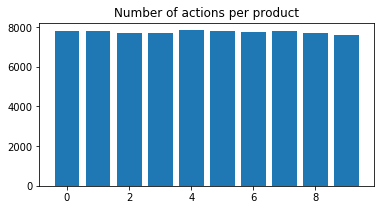

In [5]:
plt.title('Number of actions per product')
taken_actions = data[data['z'] == 'bandit']['a']
actions, action_counts = np.unique(taken_actions, return_counts=True)
plt.bar(actions, action_counts)
plt.show()

All _`Actions`_ are _*evenly*_ distributed: each product is as likely to be recommended since the logs come from the realization of a random policy (the default random agent).
It is not typical behavior (usually actions are personalized, not random), and we will relax this assumption later in the course.

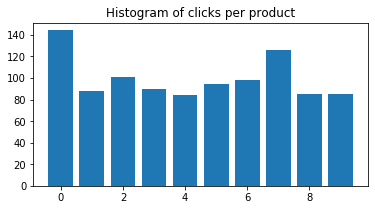

In [6]:
rewarded_actions = data[(data['z'] == 'bandit') & (data['c'] > 0)]['a']
actions, total_rewards = np.unique(rewarded_actions, return_counts=True)

plt.title('Histogram of clicks per product')
plt.bar(actions, total_rewards)
plt.show()

We can estimate a click-through rate for each recommendation by dividing the number of times we obtained a click by the number of impressions.  This produces the following "bandit best of":

In [7]:
from scipy.stats.distributions import beta

def get_beta_confidence_interval(n_impressions, n_clicks):
    n_unclicked = n_impressions - n_clicks
    low_quantile = beta.ppf(0.025, n_clicks + 1, n_unclicked + 1)
    median = beta.ppf(0.500, n_clicks + 1, n_unclicked + 1)
    high_quantile = beta.ppf(0.975, n_clicks + 1, n_unclicked + 1)
    return median - low_quantile, high_quantile - median
    

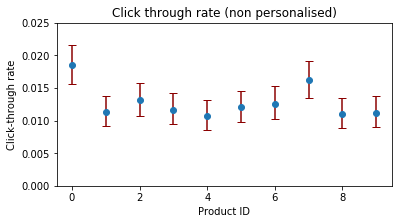

In [8]:
ctr = np.zeros(num_products)
lower_errors = np.zeros(num_products)
upper_errors = np.zeros(num_products)

for product_id in actions.astype(int):
    n_impressions = action_counts[product_id]
    n_clicks = total_rewards[product_id]
    
    lower_bound, upper_bound = get_beta_confidence_interval(n_impressions, n_clicks)
    
    ctr[product_id] = n_clicks / n_impressions
    lower_errors[product_id] = lower_bound
    upper_errors[product_id] = upper_bound

plt.title('Click through rate (non personalised)')

plt.errorbar(
    actions, ctr, yerr=(lower_errors, upper_errors),
    fmt='o', ecolor='darkred', capsize=4)

plt.ylim([0, 0.025])
plt.xlabel('Product ID')
plt.ylabel('Click-through rate')
plt.show()

## Greedy agents

### Bandit based
The non-personalised click-through rate can be used as a non-personalised agent.  It will be our first likelihood-based agent.

In [9]:
from collections import defaultdict

from recogym.agents import Agent

class SingleActionAgent(Agent):
    def __init__(self, preferred_action, config = Configuration({'num_products': 10})):
        Agent.__init__(self, config)
        self.preferred_action = preferred_action
        
    def act(self, observation, reward, done):
        probabilities = np.zeros(self.config.num_products)
        probabilities[self.preferred_action] = 1.
        return {
            **super().act(observation, reward, done),
            **{
                'a': self.preferred_action,
                'ps': probabilities[self.preferred_action],
                'ps-a': probabilities,
            },
        }

In [10]:
# Initialise your agent.
top_ctr_item = np.argmax(ctr)
print('The Greedy-Bandit agent will always take action {0}'.format(top_ctr_item))
greedy_bandit = SingleActionAgent(top_ctr_item, Configuration(env_1_args))

The Greedy-Bandit agent will always take action 0


### Organic based

The ads that attract the most clicks are not, in general, the same as the products that are often viewed organically, to see this, we can plot the organic views:

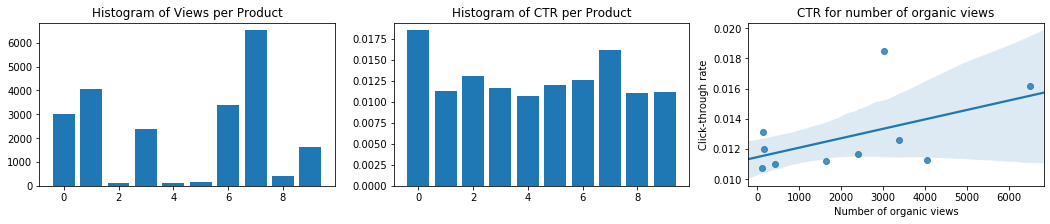

In [11]:
product_views =  data[data['z'] == 'organic']['v']
products, views_counts = np.unique(product_views, return_counts=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
axes[0].set_title('Histogram of Views per Product')
axes[0].bar(products, views_counts)

axes[1].set_title('Histogram of CTR per Product')
axes[1].bar(products, ctr)

sns.regplot(views_counts, ctr, ax=axes[2])
axes[2].set_title('CTR for number of organic views')
axes[2].set_xlabel('Number of organic views')
axes[2].set_ylabel('Click-through rate')

plt.show()

While there may be a relationship between popular products and a high click-through rate, it is certainly not guaranteed.  This fact underlies the need to use bandit feedback.  Here we will develop our final organic agent as an organic best-of to hammer this point.

In [12]:
top_viewed_item = np.argmax(views_counts)
print('The organic best-of agent will always take action {0}'.format(top_viewed_item))
greedy_organic = SingleActionAgent(top_viewed_item, Configuration(env_1_args))

The organic best-of agent will always take action 7


In [13]:
%%time
from recogym.agents import RandomAgent, random_args
from recogym.evaluate_agent import verify_agents, plot_verify_agents

random_agent = RandomAgent(Configuration({
    **env_1_args,
    **random_args,
}))

result = verify_agents(
    env, number_of_users = 5000,
    agents = {
        'Random Agent': random_agent,
        'Greedy-Organic aka. best-of': greedy_organic,
        'Greedy-Bandit': greedy_bandit,
   })

CPU times: user 1min 57s, sys: 2.02 s, total: 1min 59s
Wall time: 2min


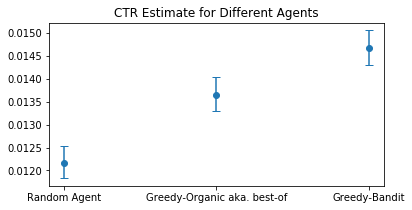

In [14]:
fig = plot_verify_agents(result)
plt.xticks(rotation=0)
plt.show()

In this environment, the bandit agent is better than best-of and random agents.